In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def f(x, y):
    "Objective function"
    return ((x/100)-3.14)**2 + ((y/100)-2.72)**2 + np.sin(3*(x/100)+1.41) + np.sin(4*(y/100)-1.73)

In [3]:
class Particle:
    def __init__(self, env, name, particles, X=np.array([1, 1]), target = [np.array([250,250]),999], waypoint = np.array([250,250]), c1=0.1, c2=0.1, w=0.8, speed=1.5433, transRange=100.0):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.stop_flag = False # when find the target stop
        self.targetFounded = False
        self.waypoint = waypoint

        self.X = X
        self.target = target
        self.V = np.random.randn(2) * 0.1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def broadcast(self):
        """Broadcast nbest to other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < self.transmission_range:  # Accoustic module Transmission range
                    particle.receive(self.pbest_position, self.pbest_fitness, self.targetFounded)
                    # if self.targetFounded:
                    #     particle.receive(self.target[0][0], self.target[0][1], self.targetFounded)
                    # else:
                    #     particle.receive(self.nbest_position, self.nbest_fitness, self.targetFounded)

    def receive(self, nbest_position, nbest_fitness, isTarget):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
            self.targetFounded = isTarget
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.waypoint = self.X + self.V

    def sensing(self):
        if not self.targetFounded:
            fitness = f(self.X[0], self.X[1])

            if fitness < self.pbest_fitness:
                self.pbest_position = self.X.copy()
                self.pbest_fitness = fitness

            if fitness < self.nbest_fitness:
                self.nbest_position = self.X.copy()
                self.nbest_fitness = fitness

    def move(self):
        if not self.stop_flag:
            if self.targetFounded:
                direction = self.nbest_position-self.X
            else:
                direction = self.waypoint-self.X
            self.X = self.X + self.speed * (direction / np.linalg.norm(direction))
            distance = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
            if distance <= 3:  # Interaction threshold
                self.update()
                #print(self.name," Updated! ", self.V, " nbest_loc ", self.nbest_position, " nbest_fit ", self.nbest_fitness)

    def targetFound(self):
        if np.linalg.norm(self.X - self.target[0]) <= 1:
            self.stop_flag = True
            self.targetFounded = True
            self.nbest_position = self.target[0].copy()
            self.nbest_fitness = self.target[1]

    def run(self):
        i = 0
        while True:
            self.targetFound()
            self.sensing()
            self.move()
            if i%5 ==0:
                self.broadcast()  # broadcast nbest to neighbors
            if i%10 ==0:    
                self.positions.append(self.X.copy()) # take the records of position
            i = i + 1
            yield self.env.timeout(1)

In [19]:
def initialize_grid_particles(n_particles, start, end):
    """Evenly distribute particles on a grid within the search space."""
    list_particles = []
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(n_particles)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create particles and assign grid positions
    for i in range(n_particles):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_particles.append(grid_position)
    
    return list_particles

In [12]:
def check_termination_condition(env, particles, target_position, threshold=1.0, radius=5):
    while True:
        count_within_radius = sum(
            np.linalg.norm(p.X - target_position) <= radius for p in particles
        )
        if (count_within_radius >= threshold * len(particles)) or (env.now >= 2000):
            #print(f"Condition met at time {env.now}: {count_within_radius}/{len(particles)} particles near target.")
            return [env.event().succeed(),count_within_radius/len(particles)]  # Trigger the event to stop simulation
        yield env.timeout(1)

In [22]:
def simulate_pso(n_particles = 20, tr=100.0):
    env = simpy.Environment()
    firstWaypoints = initialize_grid_particles(n_particles, 100, 400)
    
    x, y = np.array(np.meshgrid(np.linspace(0, 500, 5000), np.linspace(0, 500, 5000)))
    z = f(x, y)
    x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]
    target_position = np.array([x_min, y_min])  # Define the target position
    target_fitness = f(x_min, y_min)

    particles = [Particle(env, f'Particle {i}', [], waypoint=firstWaypoints[i], transRange = tr) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles
        particle.target = [target_position,target_fitness]
    
    termination_event = env.process(check_termination_condition(env, particles, target_position))
    env.run(until=termination_event)  # Simulation stops when termination_event is triggered

    count_within_radius = sum(
        np.linalg.norm(p.X - target_position) <= 5.0 for p in particles
    )

    global_best = min(particles, key=lambda p: p.pbest_fitness)
    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness, env.now, count_within_radius/n_particles

In [23]:
positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = 20, tr=45)

In [24]:
running_time, AUVpercentage

(2000, 0.15)

In [126]:
# multiple experiment
timeList = []
percentageList = []
for i in range(45,51):
    time = 0
    percentage = 0
    print("Current transmission range: ", i)
    for j in range(10):
        positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = 20, tr=i)
        time = time + running_time
        percentage = AUVpercentage + percentage
    timeList.append(time/10)
    percentageList.append(percentage/10)

Current transmission range:  45
Current transmission range:  46
Current transmission range:  47
Current transmission range:  48
Current transmission range:  49
Current transmission range:  50


In [32]:
# Number of AUVs
timeList = []
percentageList = []
for i in range(10,51):
    time = 0
    percentage = 0
    print("Number of AUVs: ", i)
    for j in range(10):
        positions, nbest, nbest_obj, running_time, AUVpercentage = simulate_pso(n_particles = i, tr=1000.0)
        time = time + running_time
        percentage = AUVpercentage + percentage
    timeList.append(time/10)
    percentageList.append(percentage/10)

Number of AUVs:  10
Number of AUVs:  11
Number of AUVs:  12
Number of AUVs:  13
Number of AUVs:  14
Number of AUVs:  15
Number of AUVs:  16
Number of AUVs:  17
Number of AUVs:  18
Number of AUVs:  19
Number of AUVs:  20
Number of AUVs:  21
Number of AUVs:  22
Number of AUVs:  23
Number of AUVs:  24
Number of AUVs:  25
Number of AUVs:  26
Number of AUVs:  27
Number of AUVs:  28
Number of AUVs:  29
Number of AUVs:  30
Number of AUVs:  31
Number of AUVs:  32
Number of AUVs:  33
Number of AUVs:  34
Number of AUVs:  35
Number of AUVs:  36
Number of AUVs:  37
Number of AUVs:  38
Number of AUVs:  39
Number of AUVs:  40
Number of AUVs:  41
Number of AUVs:  42
Number of AUVs:  43
Number of AUVs:  44
Number of AUVs:  45
Number of AUVs:  46
Number of AUVs:  47
Number of AUVs:  48
Number of AUVs:  49
Number of AUVs:  50


In [33]:
timeList

[2000.0,
 1028.4,
 1379.2,
 1335.1,
 1074.4,
 1276.9,
 685.6,
 2000.0,
 2000.0,
 990.8,
 1175.2,
 967.6,
 1172.5,
 845.6,
 432.5,
 1213.7,
 2000.0,
 2000.0,
 923.9,
 1208.6,
 1052.0,
 1053.5,
 738.6,
 738.1,
 897.3,
 1326.7,
 1368.6,
 740.9,
 584.8,
 1053.0,
 1218.7,
 734.3,
 734.2,
 580.4,
 911.8,
 1053.3,
 1057.2,
 1055.3,
 896.1,
 421.4,
 1370.8]

In [34]:
percentageList

[0.0,
 0.9545454545454545,
 0.8916666666666668,
 0.923076923076923,
 0.9714285714285715,
 0.9666666666666668,
 0.99375,
 0.0,
 0.0,
 0.9736842105263157,
 0.9349999999999998,
 0.9857142857142858,
 0.9681818181818181,
 0.9739130434782609,
 1.0,
 0.9719999999999999,
 0.0,
 0.0,
 0.9285714285714285,
 0.9379310344827585,
 0.9700000000000001,
 0.964516129032258,
 0.978125,
 0.9878787878787879,
 0.9764705882352942,
 0.9657142857142856,
 0.9472222222222222,
 0.9783783783783784,
 0.9815789473684211,
 0.9487179487179487,
 0.9375,
 0.9878048780487806,
 0.9880952380952381,
 0.9930232558139535,
 0.9795454545454545,
 0.9844444444444445,
 0.9804347826086957,
 0.9765957446808511,
 0.9770833333333332,
 1.0,
 0.958]

In [67]:
positions, nbest, nbest_obj, running_time = simulate_pso(n_particles = 20, radius = 400, tr=100.0)

Condition met at time 3000: 0/20 particles near target.


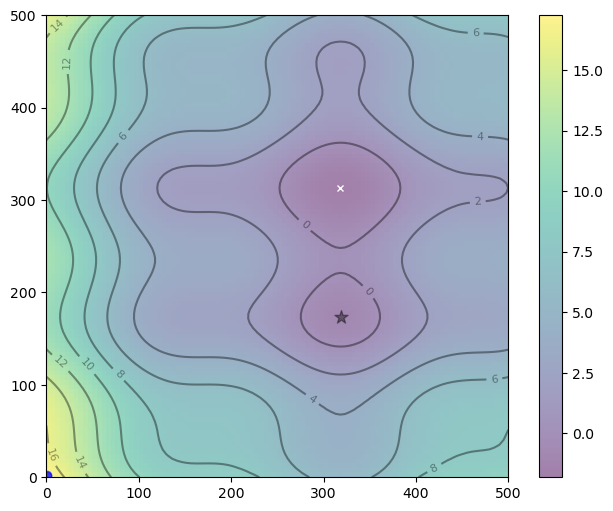

In [56]:
# Plotting and Animation
i =19
x, y = np.array(np.meshgrid(np.linspace(0, 500, 100), np.linspace(0, 500, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 500, 0, 500], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[i][0], positions[i][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

MovieWriter imagemagick unavailable; using Pillow instead.


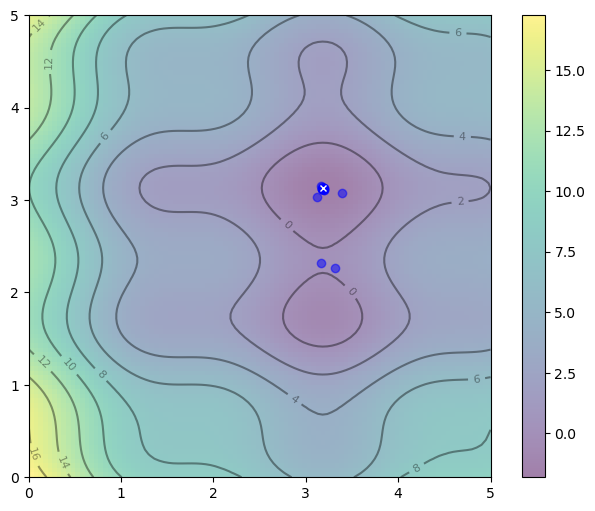

DPSO found best solution at f([3.18534561 3.12961021])=-1.8083515093824336


In [ ]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO-arc-r=5.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))


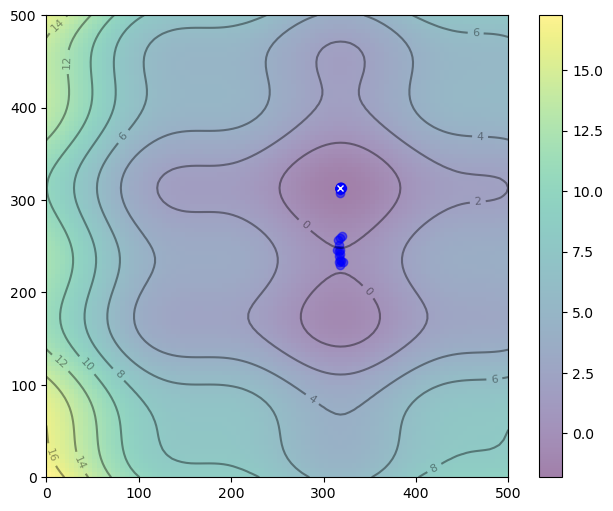

In [38]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, 500, 100), np.linspace(0, 500, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 500, 0, 500], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

i = 80
ax.clear()
ax.imshow(z, extent=[0, 500, 0, 500], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
for pos in positions:
    p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
nbest_plot.set_offsets(nbest.reshape(1, -1))
plt.show()

In [3]:
# Currently not used
def levy_step(mu=1.5):
    """Generate a step length from a Levy distribution."""
    return np.random.pareto(mu)  # Using Pareto distribution for Levy flight